In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
--2022-02-05 05:47:13--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  48.0MB/s    in 3.6s    

2022-02-05 05:47:17 (44.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/cs231n/assignments/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

lr 2.000000e-03 reg 1.000000e-04 train accuracy: 0.511367 val accuracy: 0.500000
lr 2.000000e-03 reg 2.000000e-04 train accuracy: 0.511061 val accuracy: 0.498000
lr 2.000000e-03 reg 4.000000e-04 train accuracy: 0.511163 val accuracy: 0.499000
lr 2.000000e-03 reg 8.000000e-04 train accuracy: 0.511633 val accuracy: 0.497000
lr 3.000000e-03 reg 1.000000e-04 train accuracy: 0.513531 val accuracy: 0.493000
lr 3.000000e-03 reg 2.000000e-04 train accuracy: 0.511571 val accuracy: 0.493000
lr 3.000000e-03 reg 4.000000e-04 train accuracy: 0.512265 val accuracy: 0.504000
lr 3.000000e-03 reg 8.000000e-04 train accuracy: 0.512633 val accuracy: 0.498000
lr 4.000000e-03 reg 1.000000e-04 train accuracy: 0.512163 val accuracy: 0.499000
lr 4.000000e-03 reg 2.000000e-04 train accuracy: 0.512490 val accuracy: 0.496000
lr 4.000000e-03 reg 4.000000e-04 train accuracy: 0.511286 val accuracy: 0.499000
lr 4.000000e-03 reg 8.000000e-04 train accuracy: 0.511735 val accuracy: 0.494000
lr 6.000000e-03 reg 1.000000

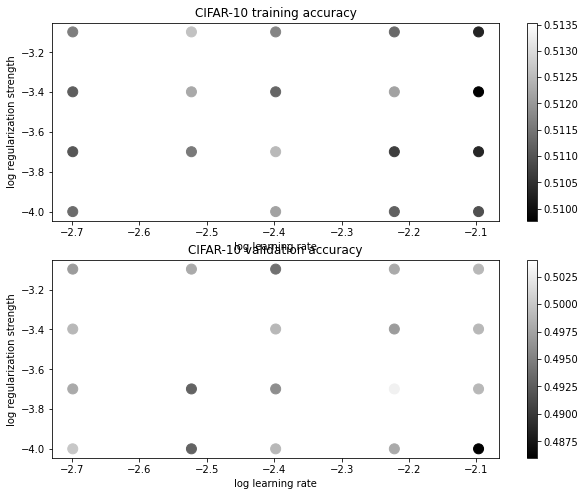

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
learning_rates = [2e-3, 3e-3, 4e-3, 6e-3, 8e-3]
regularization_strengths = [1e-4, 2e-4, 4e-4, 8e-4]

for lr in learning_rates:
  for reg in regularization_strengths:
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                          num_iters=3000, verbose=False)
    y_train_pred = svm.predict(X_train_feats)
    train_accuracy = np.mean(y_train == y_train_pred)
    y_val_pred = svm.predict(X_val_feats)
    val_accuracy = np.mean(y_val == y_val_pred)
    if val_accuracy > best_val:
      best_val = val_accuracy
      best_svm = svm
    results[(lr, reg)] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.488


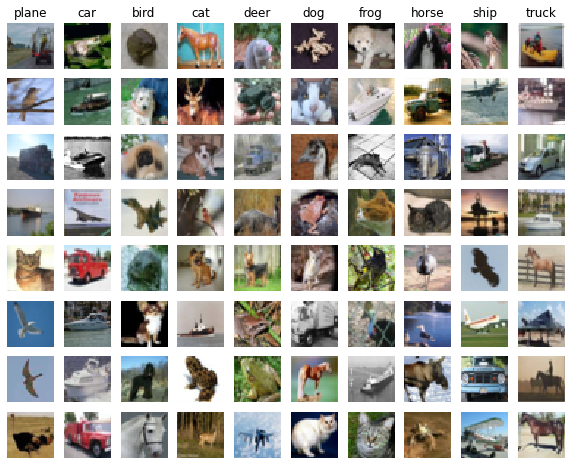

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Yes. Planes, ships and birds are easy to mistake, because all have sharp bodies and are always on blue backgrounds. Some images are classified as bird or deer because they have much green in the backgroud, which is a common feature for bird and deer images. Cars and trucks are also easy to mistake, since their HOG are almost the same. The animals are the most difficult to classify, because their bodies deform a lot, their colors vary widely, and their photos can be clipped in almost any possible way.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print(X_train_feats.shape)

(49000, 155)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_val = -1
best_stats = None

learning_rates = [.3, .4, .5]
regularization_strengths = [1e-3, 1e-4, 1e-9, 1e-10]
hidden_dims = [300, 400, 500]

for lr in learning_rates:
  for reg in regularization_strengths:
    for h in hidden_dims:
      net = TwoLayerNet(input_dim, h, num_classes)
      stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                  num_iters=2000, batch_size=200,
                  learning_rate=lr, learning_rate_decay=0.95,
                  reg=reg, verbose=False)
      val_acc = stats['val_acc_history'][-1]
      print('h %3d lr %e reg %e val accuracy: %f' % (h, lr, reg, val_acc))
      if val_acc > best_val:
        best_val = val_acc
        best_stats = stats
        best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

h 300 lr 3.000000e-01 reg 1.000000e-03 val accuracy: 0.590000
h 400 lr 3.000000e-01 reg 1.000000e-03 val accuracy: 0.579000
h 500 lr 3.000000e-01 reg 1.000000e-03 val accuracy: 0.584000
h 300 lr 3.000000e-01 reg 1.000000e-04 val accuracy: 0.596000
h 400 lr 3.000000e-01 reg 1.000000e-04 val accuracy: 0.589000
h 500 lr 3.000000e-01 reg 1.000000e-04 val accuracy: 0.590000
h 300 lr 3.000000e-01 reg 1.000000e-09 val accuracy: 0.573000
h 400 lr 3.000000e-01 reg 1.000000e-09 val accuracy: 0.593000
h 500 lr 3.000000e-01 reg 1.000000e-09 val accuracy: 0.591000
h 300 lr 3.000000e-01 reg 1.000000e-10 val accuracy: 0.578000
h 400 lr 3.000000e-01 reg 1.000000e-10 val accuracy: 0.583000
h 500 lr 3.000000e-01 reg 1.000000e-10 val accuracy: 0.584000
h 300 lr 4.000000e-01 reg 1.000000e-03 val accuracy: 0.586000
h 400 lr 4.000000e-01 reg 1.000000e-03 val accuracy: 0.585000
h 500 lr 4.000000e-01 reg 1.000000e-03 val accuracy: 0.578000
h 300 lr 4.000000e-01 reg 1.000000e-04 val accuracy: 0.576000
h 400 lr

In [ ]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.585


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

### DCT Features

Apply discrete cosine transform (DCT) and then a low-pass filter to an image. This function extract the low frequency information in the image, so it reduces the noise and tells generally where in the image does a color appear.

This gives finer details than simply using the color histogram. For example, if one image is blue at the bottom, as for ships, and the other is blue at the top, as for trucks and cars, then the color histogram cannot tell them apart, yet the corresponding coefficients of DCT for them are generally opposite.

In [34]:
def dct_low_freq(im):
  """
  Compute 2-D DCT for each channel of an image.
  Return the low frequency coefficients only.

    Parameters:
      im: H x W x C array of pixel data for an RGB image.

    Returns:
      feats: (H//4 + 1) x (W//4 + 1) x C real spectrum array flat.
  
  """
  from scipy.fftpack import dct
  H, W, C = im.shape
  feats = dct(dct(im, axis=0), axis=1)[:H//4 + 1, :W//4 + 1]

  return feats.ravel()

Together with HOG features, this is expected to outperform the HOG + Color histogram.

In [35]:
from cs231n.features import *

feature_fns = [hog_feature, dct_low_freq]
X_train_feats = extract_features(X_train, feature_fns, verbose=False)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True) + 1e-15
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

print(X_train_feats.shape)

(49000, 388)


In [31]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
num_classes = 10

best_net = None
best_val = -1
best_stats = None
results = {}

learning_rates = np.random.uniform(.1, .2, 50)
regularization_strengths = np.random.uniform(5e-7, 2e-6, 50)
hidden_dims = [150]

for lr, reg in zip(learning_rates, regularization_strengths):
    for h in hidden_dims:
      net = TwoLayerNet(input_dim, h, num_classes)
      stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                  num_iters=3000, batch_size=200,
                  learning_rate=lr, learning_rate_decay=0.95,
                  reg=reg, verbose=False)
      val_acc = stats['val_acc_history'][-1]
      print('h %3d lr %e reg %e val accuracy: %f' % (h, lr, reg, val_acc))
      if val_acc > best_val:
        best_val = val_acc
        best_stats = stats
        best_net = net
      results[(lr, reg)] = val_acc

print('best validation accuracy achieved during cross-validation: %f' % best_val)

h 150 lr 1.560159e-01 reg 7.873678e-07 val accuracy: 0.636000
h 150 lr 1.769715e-01 reg 8.954709e-07 val accuracy: 0.631000
h 150 lr 1.209833e-01 reg 7.917656e-07 val accuracy: 0.622000
h 150 lr 1.380252e-01 reg 1.506744e-06 val accuracy: 0.628000
h 150 lr 1.099161e-01 reg 7.112436e-07 val accuracy: 0.610000
h 150 lr 1.265023e-01 reg 1.862345e-06 val accuracy: 0.623000
h 150 lr 1.498079e-01 reg 1.976217e-06 val accuracy: 0.624000
h 150 lr 1.856945e-01 reg 1.792751e-06 val accuracy: 0.628000
h 150 lr 1.204704e-01 reg 1.724004e-06 val accuracy: 0.631000
h 150 lr 1.481998e-01 reg 1.603980e-06 val accuracy: 0.631000
h 150 lr 1.579210e-01 reg 5.814903e-07 val accuracy: 0.636000
h 150 lr 1.700373e-01 reg 1.699711e-06 val accuracy: 0.616000
h 150 lr 1.197760e-01 reg 7.386498e-07 val accuracy: 0.619000
h 150 lr 1.956331e-01 reg 1.126803e-06 val accuracy: 0.616000
h 150 lr 1.812775e-01 reg 1.372702e-06 val accuracy: 0.629000
h 150 lr 1.894901e-01 reg 6.427642e-07 val accuracy: 0.627000
h 150 lr

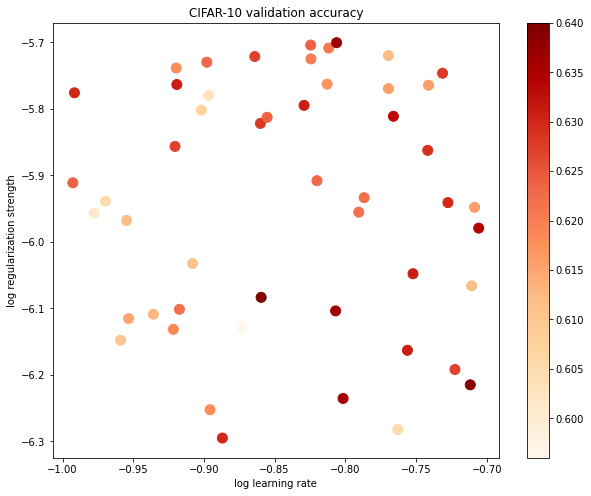

In [32]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot validation accuracy
marker_size = 100
colors = [results[x] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='OrRd')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [33]:
# Run on the test set.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.634


# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!